# CSCA 5622 Machine Learning I Final Project

**Goal**: Identify a Supervised Learning problem to perform EDA and model analysis.

### Deliverables

1. Jupyter notebook showing a supervised learning problem description, EDA procedure, analysis (model building and training), result, and discussion/conclusion
2. Video presentation or demo (5-15min) in `.mp4` format.

   - What problem do you solve?
   - What ML approach do you use, or what methods does your app use?
   - Show the result or run an app demo.

3. [Public GitHub Repo](https://github.com/davidhwilliams/CSCA-5622-ML-I-Final)


# Project Focus

Predicting CVSS Score Severity based on `description`, `CPEs`, `keywords`.

## Links and Data Feeds

- https://nvd.nist.gov/vuln
- [NVD CVE API Guide](https://nvd.nist.gov/developers/vulnerabilities)

## Steps

### 1. Data Collection

- **Download CVE Dataset** from the NVD.


### 2. Data Preprocessing

1. Sets up the directory paths for the current working directory and the data directory containing the JSON files.
2. Iterates through each JSON file for the specified years, loading and aggregating the CVE items.
3. Converts the aggregated CVE items into a pandas DataFrame for easier processing.
4. Flattens the nested description data and merges it back into the main DataFrame.
5. Drops unnecessary columns and fields, including metadata and nested description data.
6. Filters out records that do not have CVSS v3 base scores.
7. Saves the cleaned data to a JSON file.

- **Handle missing data**: Remove or impute missing values in descriptions, affected software, and CVSS scores.
- **Text preprocessing**: For vulnerability descriptions:Remove special characters, stop words, and tokenize. Apply lemmatization or stemming.
- **Keyword extraction**: Use TF-IDF or CountVectorizer (bag-of-words).
- **Categorical encoding** for affected software/hardware: One-hot encoding or label encoding. Use dimensionality reduction techniques like PCA.


In [1]:
import json
import pandas as pd
import os

# Get the current working directory (location of the Jupyter Notebook)
notebook_dir = os.getcwd()

# Directory containing the JSON files relative to the notebook location
data_dir = os.path.join(notebook_dir, "data")

# Loop through each file and combine the data
all_data = []
for year in range(2020, 2025):
    file_path = os.path.join(data_dir, f"nvdcve-1.1-{year}.json")
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
        all_data.extend(data["CVE_Items"])

# Extract CVE Items
cve_items = data["CVE_Items"]



# Convert to DataFrame for easier processing
df = pd.json_normalize(cve_items)

# Flatten and drop the lang in the cve.description.description_data field
description_data = pd.json_normalize(
    cve_items,
    record_path=["cve", "description", "description_data"],
    record_prefix="description_data.",
)

# Drop the lang field from the flattened description data
description_data = description_data.drop(columns=["description_data.lang"])

# Merge the flattened description data back into the main DataFrame
df = df.merge(
    description_data[["description_data.value"]],
    left_index=True,
    right_index=True,
    how="left",
    suffixes=("", "_description"),
)

# Drop the original nested description_data field
df = df.drop(columns=["cve.description.description_data"])

# Drop unnecessary columns (adjust based on the dataset)
df = df.drop(
    columns=[
        # metadata
        "cve.data_type",
        "cve.data_format",
        "cve.data_version",
        "cve.problemtype.problemtype_data",
        "cve.references.reference_data",
        "configurations.CVE_data_version",
        "configurations.nodes",
    ],
)

# Drop all columns with impact.baseMetricV2
df = df[df.columns.drop(list(df.filter(regex="impact.baseMetricV2")))]

# Only keep records with CVSS v3 scores - impact.baseMetricV3.cvssV3.baseScore
df = df[df["impact.baseMetricV3.cvssV3.baseScore"].notnull()]

# Clean up the description_data.value column by removing punctuation and stopwords and converting to lowercase
df["description_data.value"] = (
    df["description_data.value"].str.replace(r"[^\w\s]", "").str.lower()
)
# Remove stopwords from stopwords.txt
with open(os.path.join(data_dir, "stopwords.txt"), "r") as f:
    stopwords = f.read().splitlines()
df["description_data.value"] = df["description_data.value"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stopwords])
)

# Save the cleaned data to a JSON file and a pretty-printed JSON file
with open(
    os.path.join(data_dir, "cleaned_cve_data_pretty.json"), "w", encoding="utf-8"
) as f:
    json.dump(df.to_dict(orient="records"), f, indent=4)

df.to_json(os.path.join(data_dir, "cleaned_cve_data.json"), orient="records")

### 3. Exploratory Data Analysis (EDA)

1. Plotting Histograms:
   - Create a grid of subplots to display histograms for CVSS v3 base scores, exploitability scores, and impact scores.
2. Generating a Word Cloud:
   - It combines all CVE descriptions into a single string.
   - Defines additional stopwords to exclude from the word cloud.
   - Generates and displays a word cloud from the combined text.
   - Prints the top 10 most frequent words in the word cloud.

- **Understand the target variable**: Plot the distribution of CVSS severity (Low, Medium, High, Critical). Check for class imbalance.
- **Analyze text data**:
  - Word cloud visualizations for different severity levels.
  - Bar plots for keyword frequency by severity category.
- **Analyze affected software/hardware**:
  - Histograms or bar charts for common affected software/hardware in each severity.
- **Correlation analysis**:
  - Correlation matrix to identify strong relationships between features and CVSS severity.


Top 10 words: cross site, site scripting, plugin wordpress, disclosed public, public used, remotely disclosed, authenticated attacker, manipulation argument, including due, stored cross


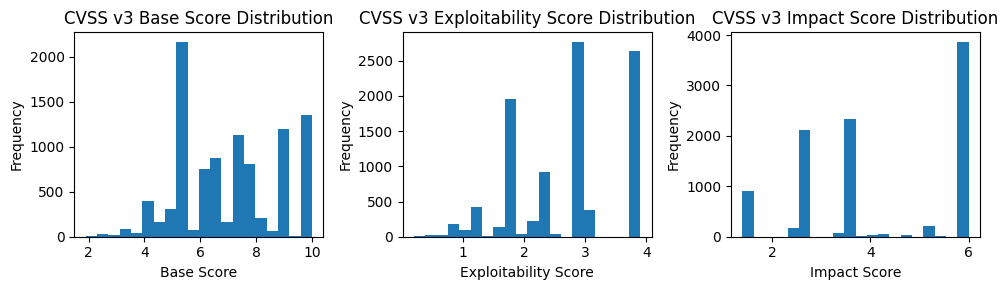

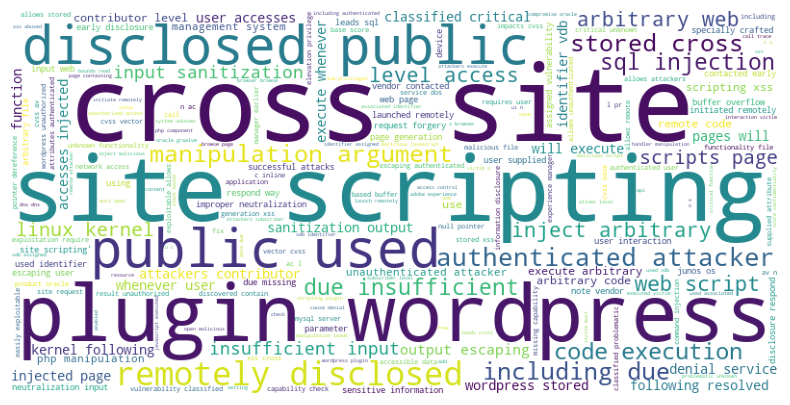

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Plot the distribution of CVSS v3 base scores, exploitability, and impact scores on a 3x1 grid
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].hist(df["impact.baseMetricV3.cvssV3.baseScore"], bins=20)
axs[0].set_title("CVSS v3 Base Score Distribution")
axs[0].set_xlabel("Base Score")
axs[0].set_ylabel("Frequency")

axs[1].hist(df["impact.baseMetricV3.exploitabilityScore"], bins=20)
axs[1].set_title("CVSS v3 Exploitability Score Distribution")
axs[1].set_xlabel("Exploitability Score")
axs[1].set_ylabel("Frequency")

axs[2].hist(df["impact.baseMetricV3.impactScore"], bins=20)
axs[2].set_title("CVSS v3 Impact Score Distribution")
axs[2].set_xlabel("Impact Score")
axs[2].set_ylabel("Frequency")

plt.tight_layout()

# Create a Word cloud of the CVE descriptions
text = " ".join(df["description_data.value"].values)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(wordcloud)

# Print the top 10 most popular words
top_words = sorted(wordcloud.words_.items(), key=lambda item: item[1], reverse=True)[
    :10
]
print("Top 10 words: " + ", ".join([word for word, _ in top_words]))

### 4. Feature Engineering

- **Text-based features**:
  - Use TF-IDF or Word2Vec for numerical representations.
  - Create features based on keyword counts, description length, etc.
- **Categorical features**:
  - Count the number of affected products or types of products.
- **Date-based features** (if applicable): Create features like vulnerability age, seasonality, etc.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the CVE descriptions to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the CVE descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df["description_data.value"])

# Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Display the shape of the TF-IDF DataFrame
print(tfidf_df.shape)

# Display the top 10 most important words based on the TF-IDF scores
top_words = tfidf_df.mean().sort_values(ascending=False)[:10]
print("Top 10 words: " + ", ".join(top_words.index))

# Display the feature names (words) from the TF-IDF vectorizer
print(tfidf_vectorizer.get_feature_names_out())

(9838, 28674)
Top 10 words: user, site, code, file, plugin, cross, access, remote, arbitrary, attackers
['00' '000' '0000' ... 'zyxel' 'zzcms' 'zzz']


### 5. Model Selection and Training

- Split the data into **training** and **testing** sets (70/30 or 80/20 split).
- Use classification models:
  - **Logistic Regression** (baseline model).
  - **Random Forest**.
  - **Gradient Boosting (XGBoost/LightGBM)**.
  - **Naive Bayes** for text-heavy models.
  - **Support Vector Machine (SVM)** with TF-IDF.
- Handle **class imbalance** using:
  - **Oversampling** (SMOTE) or **undersampling**.
  - Adjust class weights in models.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

random_state = 42

# Split the data into training and testing sets and train a Random Forest Regressor
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df,
    df["impact.baseMetricV3.cvssV3.baseScore"],
    test_size=0.2,
    random_state=random_state,
)

# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=30,  # Reduced number of trees to speed up training
    max_depth=10,  # Limit the depth of each tree
    min_samples_split=10,  # Increase the minimum number of samples required to split
    min_samples_leaf=4,  # Set minimum samples per leaf to avoid deep trees
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    random_state=random_state,
)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=30, n_jobs=-1, random_state=42)

### 6. Model Evaluation

- Use metrics:
  - **Accuracy** (for balanced data).
  - **Precision, Recall, F1-score** (for imbalanced data).
  - **Confusion Matrix** to visualize performance.
- **Cross-validation**: Use k-fold cross-validation for generalization.


In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the Random Forest Regressor
# Predict the CVSS v3 base scores for the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
accuracy = rf_regressor.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
precision = rf_regressor.score(X_test, y_test)
print(f"Precision: {precision}")


Mean Squared Error: 1.39730510874409
R-squared: 0.5391785527039324
Accuracy: 0.5391785527039323
Precision: 0.5391785527039323


### 7. Model Tuning

- **Hyperparameter tuning** with:
  - **GridSearchCV** or **RandomSearchCV**.
  - Tune parameters like number of estimators, tree depth, learning rate.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    "n_estimators": [30, 50, 100],
    "max_depth": [10, 20, 30],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 4, 6],
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(warm_start=True, random_state=random_state),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=2,  # 2-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,  # Verbosity level
    random_state=random_state,
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_rf_regressor = random_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best estimator: {best_rf_regressor}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits


KeyboardInterrupt: 

### 8. Model Interpretation

- **Feature importance**: Visualize feature importance for tree-based models.
- **SHAP values or LIME** for interpreting complex models.

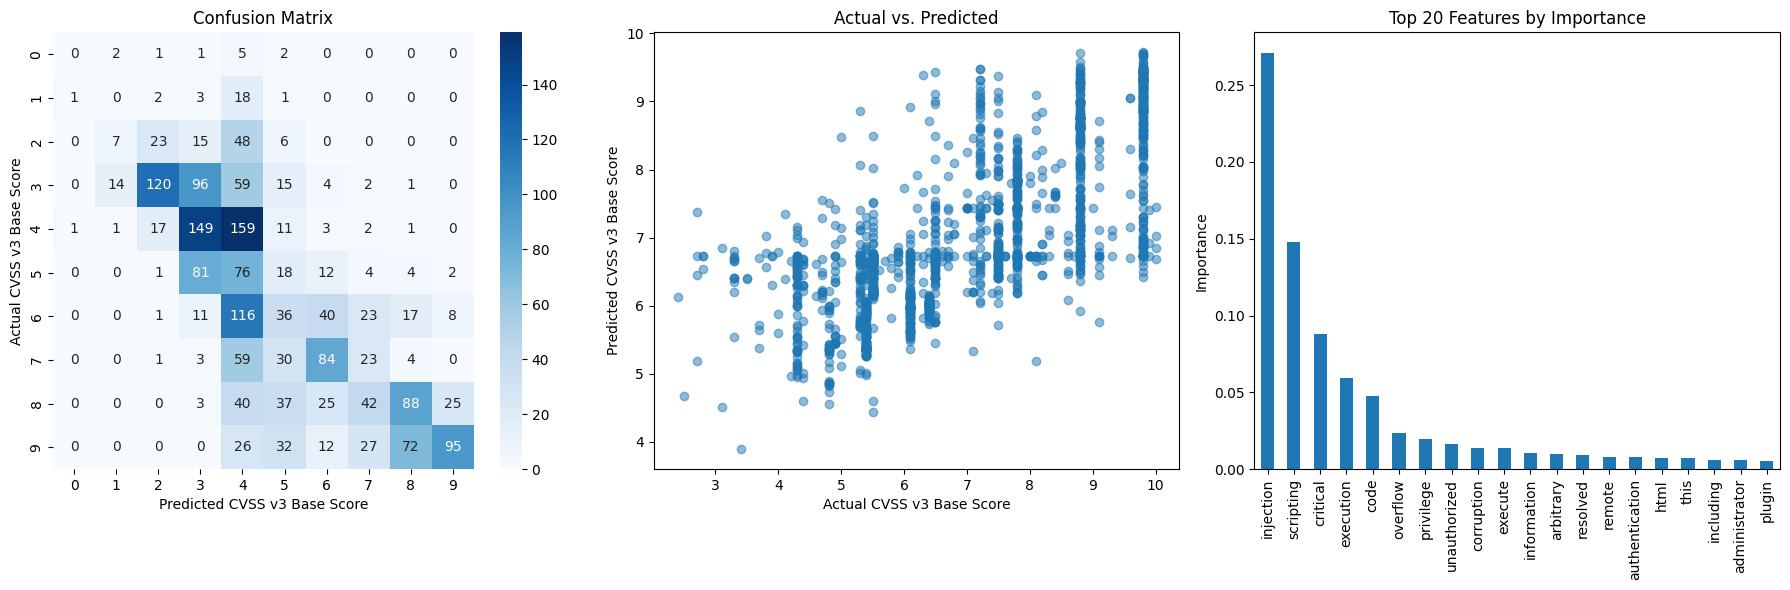

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the Confusion Matrix, Actual vs. Predicted, and Feature Importance in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
y_test_discrete = pd.cut(y_test, bins=10, labels=False)
y_pred_discrete = pd.cut(y_pred, bins=10, labels=False)
cm = confusion_matrix(y_test_discrete, y_pred_discrete)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_xlabel("Predicted CVSS v3 Base Score")
axs[0].set_ylabel("Actual CVSS v3 Base Score")
axs[0].set_title("Confusion Matrix")

# Actual vs. Predicted
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_xlabel("Actual CVSS v3 Base Score")
axs[1].set_ylabel("Predicted CVSS v3 Base Score")
axs[1].set_title("Actual vs. Predicted")

# Feature Importance
feature_importance = pd.Series(
    rf_regressor.feature_importances_, index=tfidf_df.columns
).sort_values(ascending=False)
feature_importance.head(20).plot(kind="bar", ax=axs[2])
axs[2].set_title("Top 20 Features by Importance")
axs[2].set_ylabel("Importance")

plt.tight_layout()

### 9. Model Deployment and Conclusions

- Discuss which features (descriptions, keywords, software) were most predictive.
- Identify limitations (e.g., class imbalance, noisy text data).
- Suggest improvements with more data or refined feature engineering.
